In [3]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
import math

In [4]:
dataset_path = Path().resolve().parent/'dataset/HomeC.csv'
df = pd.read_csv(dataset_path)
dataset_path

C:\Users\ngxin\anaconda3\envs\time-series-labs\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (0,27) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


WindowsPath('C:/Users/ngxin/projects/Capstone-Project-Time-Series-Forecasting/dataset/HomeC.csv')

In [5]:
# clean data 
#remove kW
df.columns = [i.replace(' [kW]', '') for i in df.columns]
#combine similar objects
df['Furnace'] = df[['Furnace 1','Furnace 2']].sum(axis=1)
df['Kitchen'] = df[['Kitchen 12','Kitchen 14','Kitchen 38']].sum(axis=1)
#remove unused objects; icon and summary are objects that cannot be passed into calculation; use column same as House overall column and gen column same as Solar column
df.drop(['Furnace 1','Furnace 2','Kitchen 12','Kitchen 14','Kitchen 38','icon','House overall','summary','Solar'],axis = 1,inplace = True)
#remove last row as the values are NaN
df = df[0:-1] ## == dataset[0:dataset.shape[0]-1] == dataset[0:len(dataset)-1] == dataset[:-1]
#replace object in cloudCover with float
df['cloudCover'].replace(['cloudCover'], method='bfill', inplace=True)
df['cloudCover'] = df['cloudCover'].astype('float')
#set date time as index and drop time column
date_time = pd.date_range('2016-01-01 00:00',periods=len(df), freq='min')
df = df.set_index(date_time)
df = df.drop(['time'],axis=1)
df

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,...,29.26,1016.91,9.18,0.75,282.0,0.0000,24.40,0.00,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.727683,0.000633
2016-12-15 22:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,0.729050,0.000600
2016-12-15 22:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.060117,0.000600
2016-12-15 22:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,...,29.45,1011.49,6.72,0.31,186.0,0.0101,31.27,0.51,1.116033,0.000650


In [6]:
df.columns

Index(['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room',
       'temperature', 'humidity', 'visibility', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability', 'Furnace', 'Kitchen'],
      dtype='object')

In [7]:
# Since the dataset has both energy and weather data, it is better we seperate them to do the resample method on them separately
energy_data = df[['use', 'gen', 'Dishwasher', 'Home office', 'Fridge', 'Wine cellar',
       'Garage door', 'Barn', 'Well', 'Microwave', 'Living room', 'Furnace', 'Kitchen']]
energy_data

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen
2016-01-01 00:00:00,0.932833,0.003483,0.000033,0.442633,0.124150,0.006983,0.013083,0.031350,0.001017,0.004067,0.001517,0.082617,0.000567
2016-01-01 00:01:00,0.934333,0.003467,0.000000,0.444067,0.124000,0.006983,0.013117,0.031500,0.001017,0.004067,0.001650,0.084533,0.000567
2016-01-01 00:02:00,0.931817,0.003467,0.000017,0.446067,0.123533,0.006983,0.013083,0.031517,0.001000,0.004067,0.001650,0.083017,0.000617
2016-01-01 00:03:00,1.022050,0.003483,0.000017,0.446583,0.123133,0.006983,0.013000,0.031500,0.001017,0.004067,0.001617,0.175417,0.000650
2016-01-01 00:04:00,1.139400,0.003467,0.000133,0.446533,0.122850,0.006850,0.012783,0.031500,0.001017,0.004067,0.001583,0.300917,0.000783
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-15 22:25:00,1.601233,0.003183,0.000050,0.041783,0.005267,0.008667,0.013483,0.032283,0.000983,0.003800,0.000967,0.727683,0.000633
2016-12-15 22:26:00,1.599333,0.003233,0.000050,0.041750,0.005233,0.008433,0.013433,0.032200,0.000950,0.003800,0.000933,0.729050,0.000600
2016-12-15 22:27:00,1.924267,0.003217,0.000033,0.042033,0.004983,0.008467,0.012933,0.032283,0.001000,0.003750,0.001000,1.060117,0.000600
2016-12-15 22:28:00,1.978200,0.003217,0.000050,0.042100,0.005333,0.008233,0.012817,0.032183,0.000950,0.003767,0.000950,1.116033,0.000650


In [8]:
data_per_hour = energy_data.resample("H").mean()
data_per_day = data_per_hour.resample("D").sum()
data_per_day

,use,gen,Dishwasher,Home office,Fridge,Wine cellar,Garage door,Barn,Well,Microwave,Living room,Furnace,Kitchen
2016-01-01,30.169358,0.317042,1.511709,2.412829,1.861382,0.520959,0.317472,1.861023,0.593007,0.305312,1.651724,9.901133,0.300536
2016-01-02,30.680708,1.267473,1.417092,2.596195,1.581644,0.401265,0.320350,3.093627,0.574394,0.149122,1.225093,10.860203,0.264237
2016-01-03,26.187171,1.235253,0.874388,3.245975,1.208789,0.548216,0.325906,2.445893,0.574806,0.402037,0.490139,10.220414,0.315454
2016-01-04,28.818997,1.808189,1.333297,2.704526,1.442371,0.516945,0.318994,0.773784,0.681146,0.317146,1.383365,11.703699,0.286346
2016-01-05,22.561987,2.468598,0.864458,2.434545,1.038065,0.348283,0.335705,0.819395,0.266947,0.204151,0.733608,13.359033,0.142002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-11,25.590984,1.372025,0.002347,0.996472,1.136416,0.673359,0.339841,0.787546,0.429667,0.078991,1.505487,11.926358,0.185857
2016-12-12,27.150711,0.138324,1.172576,0.994575,1.496105,0.679480,0.363111,0.786408,0.325723,0.118301,2.543310,8.903855,0.199664
2016-12-13,16.241008,0.700743,0.003602,0.990577,0.963133,0.730672,0.325437,0.813290,0.233284,0.103287,0.783238,8.326470,0.093495
2016-12-14,20.486863,0.868650,0.011463,1.007213,1.271051,0.610797,0.348407,0.790702,0.178695,0.694859,1.454539,9.010939,0.095405


<AxesSubplot:>

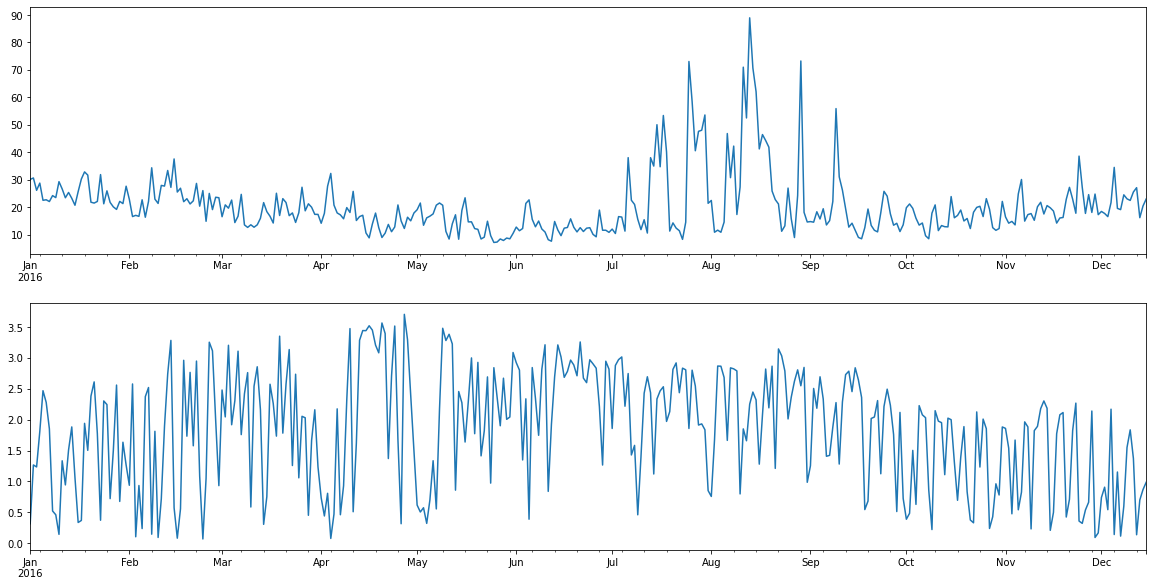

In [9]:
fig, axes = plt.subplots(nrows=2, ncols =1)
data_per_day["use"].plot(ax=axes[0],figsize = (20,10))
data_per_day["gen"].plot(ax=axes[1],figsize = (20,10))

In [10]:
weather_data = df[['temperature', 'humidity', 'visibility', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability']]

In [12]:
weather_per_day = weather_data.resample("D").mean()
# In this notebook, we are not going to use weather data

# Univariate MLP model (energy usage predict energy usage)

In [13]:
data_per_day_usage = pd.DataFrame(data_per_day["use"])
data_per_day_usage.shape

(350, 1)

In [14]:
split_ratio = 0.7
split_data = round(len(data_per_day_usage)*split_ratio)
split_data

245

In [15]:
train_data = data_per_day_usage[:split_data]
test_data = data_per_day_usage[split_data:]
train_time = data_per_day_usage.index[:split_data]
test_time = data_per_day_usage.index[split_data:]

In [16]:
train_data.shape

(245, 1)

In [17]:
test_data.shape

(105, 1)

In [18]:
scaler = StandardScaler().fit(train_data)
train_scaler = scaler.transform(train_data)
test_scaler = scaler.transform(test_data)
train_scaler

array([[ 6.88716552e-01],
       [ 7.29134890e-01],
       [ 3.73954891e-01],
       [ 5.81980709e-01],
       [ 8.74115676e-02],
       [ 1.02858541e-01],
       [ 5.18124241e-02],
       [ 2.22294765e-01],
       [ 1.65291683e-01],
       [ 6.23426708e-01],
       [ 4.14085228e-01],
       [ 1.60733878e-01],
       [ 3.12865425e-01],
       [ 1.45356879e-01],
       [-5.49120020e-02],
       [ 3.37914010e-01],
       [ 7.00112382e-01],
       [ 9.04143441e-01],
       [ 8.12471413e-01],
       [ 3.25549919e-02],
       [ 7.62749611e-03],
       [ 5.45323613e-02],
       [ 8.26623210e-01],
       [-1.28999500e-02],
       [ 3.59552156e-01],
       [ 2.60885322e-02],
       [-1.01579784e-01],
       [-1.74311691e-01],
       [ 5.60241332e-02],
       [-7.20406595e-03],
       [ 4.92726698e-01],
       [ 1.15715887e-01],
       [-3.79625125e-01],
       [-3.45392998e-01],
       [-3.73800358e-01],
       [ 1.02017178e-01],
       [-3.99245670e-01],
       [ 5.68638710e-02],
       [ 1.0

In [19]:
window_size = 19
batch_size = 10
n_epoch = 100
def sliding_window(sequence, window_size):
    x,y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + window_size
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)
train_feature, train_label = sliding_window(train_scaler, window_size)
test_feature, test_label = sliding_window(test_scaler, window_size)
train_feature
train_label.shape

(226, 1)

In [20]:
trainX = torch.from_numpy(train_feature).type(torch.Tensor)
trainY = torch.from_numpy(train_label).type(torch.Tensor)
testX = torch.from_numpy(test_feature).type(torch.Tensor)
testY = torch.from_numpy(test_label).type(torch.Tensor)
trainX.shape

torch.Size([226, 19, 1])

In [21]:
train_dataset = TensorDataset(trainX, trainY)
test_dataset = TensorDataset(testX, testY)
train_iter = DataLoader(train_dataset, batch_size, shuffle=False)
test_iter = DataLoader(test_dataset, batch_size, shuffle = False)

In [22]:
class MLP(nn.Module):
    def  __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.input_layer = nn.Linear(input_size,50)
        self.dropout_layer = nn.Dropout(p=0.5)
        self.dropout_layer_1 = nn.Dropout(p=0.2)
        self.hidden_layer = nn.Linear(50, 30)
       # self.hidden_layer_1 = nn.Linear(40, 30)
        self.hidden_layer_2 = nn.Linear(30, 20)
        self.hidden_layer_3 = nn.Linear(20, 10)
        self.output_layer = nn.Linear(10, output_size)
    
    def forward(self,x):
        x = x.view(-1, input_size)                #(batch_size, number of feature)
        out = F.relu(self.input_layer(x))
        out = self.dropout_layer(out)
        out = F.relu(self.hidden_layer(out))
      #  out = self.dropout_layer(out)
      #  out = F.relu(self.hidden_layer_1(out))
   #     out = self.dropout_layer_1(out)
        out = F.relu(self.hidden_layer_2(out))
      #  out = self.dropout_layer(out)
        out = F.relu(self.hidden_layer_3(out))
        out = self.output_layer(out)
        return out

In [23]:
torch.manual_seed(123)
input_size = window_size
output_size =1
model = MLP(input_size, output_size)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [24]:
def training(num_epochs, train_iter, test_iter, optimizer, loss_fn, model):
    # Create a list of zero values to store the average loss value of each epoch
    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    for t in range (num_epochs):
        running_loss_train = 0
        running_loss_valid = 0
        for _, (train_X, train_Y) in enumerate(train_iter):
            #Forward pass
            y_train_pred = model(train_X)
            #reshape    to know if the error come from here, where the shape of the result is wrong
            y_train_pred = torch.reshape(y_train_pred, (train_Y.shape[0], train_Y.shape[1]))
            #loss
            loss_train = loss_fn(y_train_pred, train_Y)
            #zero out gradient
            optimizer.zero_grad()
            #backward pass
            loss_train.backward()
            #update parameter
            optimizer.step()
            #calculate loss
            running_loss_train += loss_train.item()*train_X.size(0)         # .item() we get the loss for one batch
        epoch_loss_train = running_loss_train/len(train_iter.dataset)
        train_loss[t] = epoch_loss_train
        
        with torch.no_grad():
            for _, (test_X, test_Y) in enumerate(test_iter):
                y_test_pred = model(test_X)
                y_test_pred = torch.reshape(y_test_pred, (test_Y.shape[0], test_Y.shape[1]))
                
                loss_test = loss_fn(y_test_pred, test_Y)
                
                running_loss_valid += loss_test.item()*test_X.size(0)
        epoch_loss_test = running_loss_valid /len(test_iter.dataset)
        
        val_loss[t] = epoch_loss_test
    return train_loss, val_loss

In [25]:
train_loss, val_loss = training(n_epoch, train_iter, test_iter, optimizer,loss_fn, model)
for i in range(n_epoch):
    print(f"Epoch{i}, train_loss: {train_loss[i]}, val_loss: {val_loss[i]}")

Epoch0, train_loss: 1.0825197677564833, val_loss: 0.2465838550828224
Epoch1, train_loss: 1.0580217954331794, val_loss: 0.23487566913976227
Epoch2, train_loss: 1.0143299531356422, val_loss: 0.20495083668204242
Epoch3, train_loss: 0.9210797548623739, val_loss: 0.1534747976030028
Epoch4, train_loss: 0.741995069173585, val_loss: 0.15821468206339104
Epoch5, train_loss: 0.707625695232269, val_loss: 0.15061754664016325
Epoch6, train_loss: 0.7011342296558144, val_loss: 0.15667402761620144
Epoch7, train_loss: 0.6754960713133348, val_loss: 0.15180359364942062
Epoch8, train_loss: 0.6683695154775561, val_loss: 0.1623497321162113
Epoch9, train_loss: 0.665578380820498, val_loss: 0.17013592229679572
Epoch10, train_loss: 0.6112213274546429, val_loss: 0.1673930264836134
Epoch11, train_loss: 0.5658579347407924, val_loss: 0.1616706594304983
Epoch12, train_loss: 0.5996586754258755, val_loss: 0.15743710559814475
Epoch13, train_loss: 0.5549487325206267, val_loss: 0.15674643729661786
Epoch14, train_loss: 0.5

In [26]:
with torch.no_grad():
    train_predict = model(trainX)
    test_predict = model(testX)

In [27]:
train_label_rescale = scaler.inverse_transform(trainY)
test_label_rescale = scaler.inverse_transform(testY)
train_prediction_rescale = scaler.inverse_transform(train_predict)
test_prediction_rescale = scaler.inverse_transform(test_predict)

In [28]:
print("Test Data \t\t\t  Forecast Data")
for i in range (len(test_label_rescale)):
    print(f"{test_label_rescale[i]} \t\t\t {test_prediction_rescale[i]}")

Test Data 			  Forecast Data
[11.655507] 			 [14.812855]
[11.0731325] 			 [15.52295]
[18.043322] 			 [16.381752]
[25.823387] 			 [18.184456]
[24.067722] 			 [16.753765]
[17.619747] 			 [17.266151]
[13.501431] 			 [13.091115]
[14.20245] 			 [13.981608]
[11.193003] 			 [15.451614]
[13.633001] 			 [13.140951]
[19.871006] 			 [17.06657]
[21.227245] 			 [19.06863]
[19.633356] 			 [17.971523]
[16.05309] 			 [16.724909]
[13.543327] 			 [14.421215]
[14.303307] 			 [13.160115]
[9.674247] 			 [16.502983]
[8.580954] 			 [15.481161]
[17.891344] 			 [15.323762]
[20.889013] 			 [15.099967]
[11.537128] 			 [12.6268]
[13.37198] 			 [13.544489]
[12.956438] 			 [12.228741]
[12.894581] 			 [13.6744995]
[23.916496] 			 [13.314182]
[16.203495] 			 [16.77341]
[17.052404] 			 [17.34152]
[19.020128] 			 [14.341253]
[15.042307] 			 [15.290982]
[15.945406] 			 [15.352356]
[12.29] 			 [14.775734]
[18.20905] 			 [15.960458]
[19.98066] 			 [18.408957]
[20.387766] 			 [17.278305]
[16.647907] 			 [19.444975]
[23.161

In [29]:
mlp_train_rmse = math.sqrt(mean_squared_error(train_label_rescale, train_prediction_rescale))
mlp_test_rmse = math.sqrt(mean_squared_error(test_label_rescale, test_prediction_rescale))

print("Train Score : %.2f RMSE" %(mlp_train_rmse))
print("Test Score : %.2f RMSE" %(mlp_test_rmse))

Train Score : 5.42 RMSE
Test Score : 5.77 RMSE


In [30]:
mlp_train_mape = mean_absolute_percentage_error(train_label_rescale, train_prediction_rescale)
mlp_test_mape = mean_absolute_percentage_error(test_label_rescale, test_prediction_rescale)
print("Train Score: %.2f MAPE" %(mlp_train_mape))
print("Test Score: %.2f MAPE" %(mlp_test_mape))

Train Score: 0.21 MAPE
Test Score: 0.20 MAPE


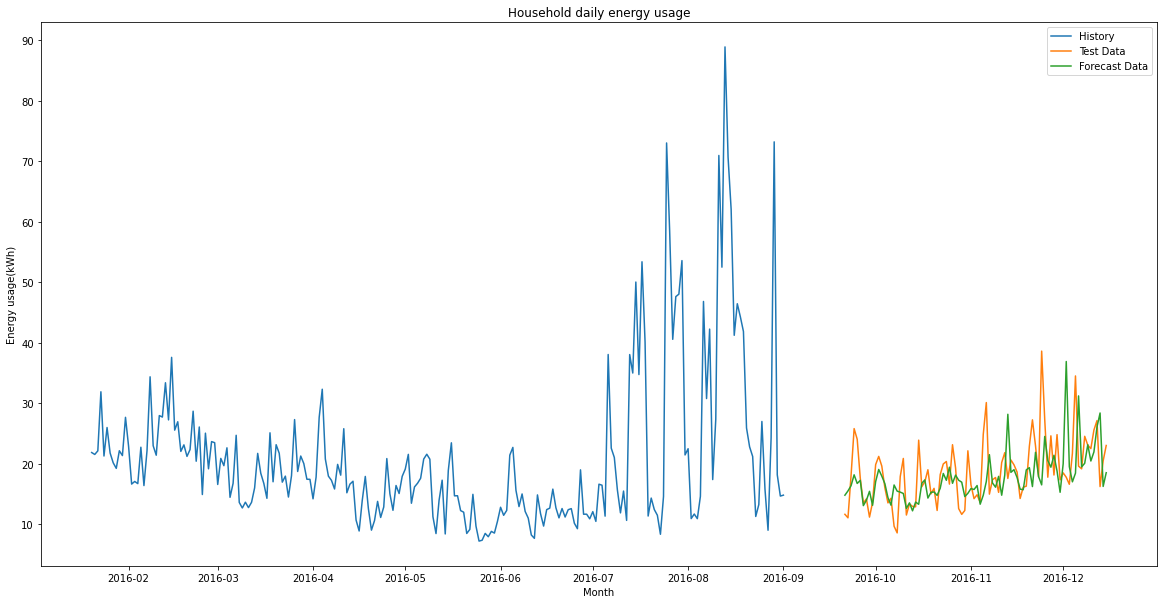

In [31]:
plt.figure(figsize=(20,10))
plt.plot(train_time[window_size:], train_label_rescale, label= "History")
plt.plot(test_time[window_size:], test_label_rescale, label = "Test Data")
plt.plot(test_time[window_size:], test_prediction_rescale, label = "Forecast Data")
plt.legend()
plt.title("Household daily energy usage")
plt.legend()
plt.xlabel("Month")
plt.ylabel("Energy usage(kWh)")
plt.show()